# Step 9: Hypermater Tuning

In this step of the project we will perform hyperparameter optmization.

Since the final model we landed on was NayveBayes we will simply check for the different implementation and evaluate which one provides the best results.

In step 7 Gradient Boosting seemed to provide interesting results but showed what seemed like overfitting. We will perfomer hyperparameter tuning for this model and do an overfitting analysis to try and optimize the results and check them agaisnt the NayveBayes model.

In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer, Group_Age_Range, Group_Ethnicity

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Hypothesis 1: NayveBayes

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [3]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    roc_scorer = make_scorer(accuracy_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=roc_scorer)
    print(roc_aucs)

In [4]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

precision = precision_score(y_test, y_pred_test, pos_label=True)
recall = recall_score(y_test, y_pred_test, pos_label=True)
print(f"GaussianNB - Precission: {precision} ; Recall: {recall}")

# Check transformed data

model = BernoulliNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

precision = precision_score(y_test, y_pred_test, pos_label=True)
recall = recall_score(y_test, y_pred_test, pos_label=True)
print(f"BernoulliNB - Precission: {precision} ; Recall: {recall}")

# Check transformed data

model = MultinomialNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

precision = precision_score(y_test, y_pred_test, pos_label=True)
recall = recall_score(y_test, y_pred_test, pos_label=True)
print(f"MultinomialNB - Precission: {precision} ; Recall: {recall}")

GaussianNB - Precission: 0.2168954938644136 ; Recall: 0.8208898405900548
BernoulliNB - Precission: 0.19164151214603997 ; Recall: 0.5075422317392339
MultinomialNB - Precission: 0.1981085571358151 ; Recall: 0.5163454675231978


In [5]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']


    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    roc_scorer = make_scorer(accuracy_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=roc_scorer)
    print(roc_aucs)

In [6]:
model = CategoricalNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

precision = precision_score(y_test, y_pred_test, pos_label=True)
recall = recall_score(y_test, y_pred_test, pos_label=True)
print(f"CategoricalNB - Precission: {precision} ; Recall: {recall}")

CategoricalNB - Precission: 0.1924401156260932 ; Recall: 0.49735902926481085


# Predict

In [7]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    roc_scorer = make_scorer(accuracy_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=roc_scorer)
    print(roc_aucs)

In [8]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

In [9]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate Best One

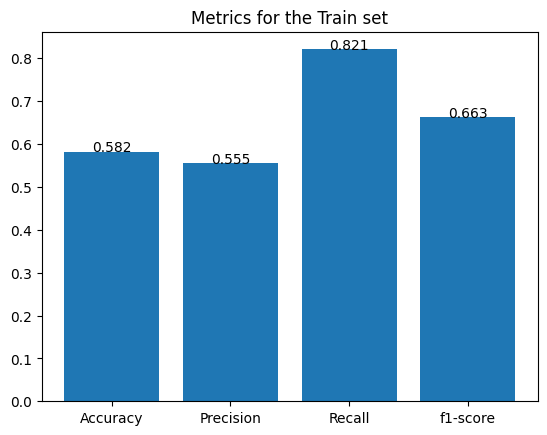

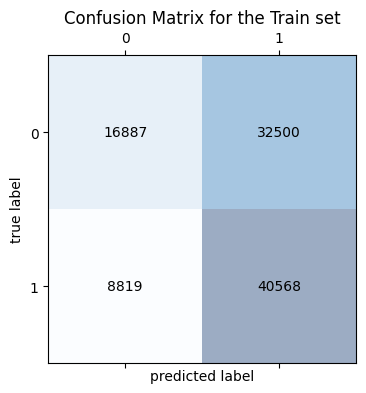

In [10]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

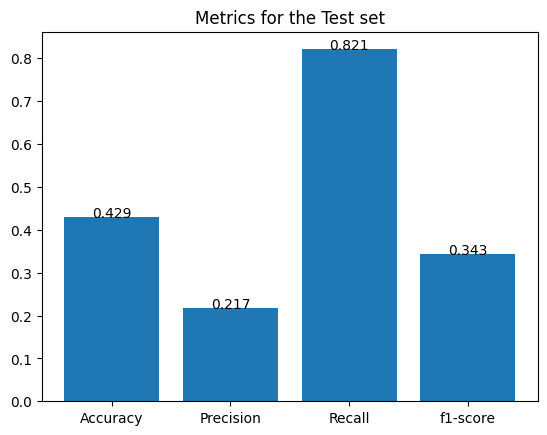

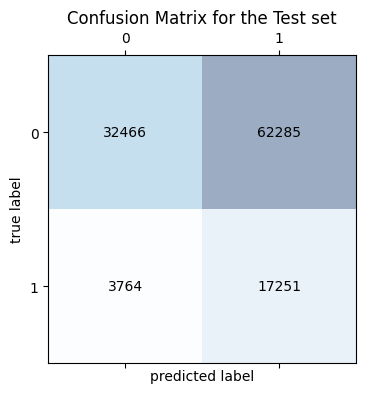

In [11]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

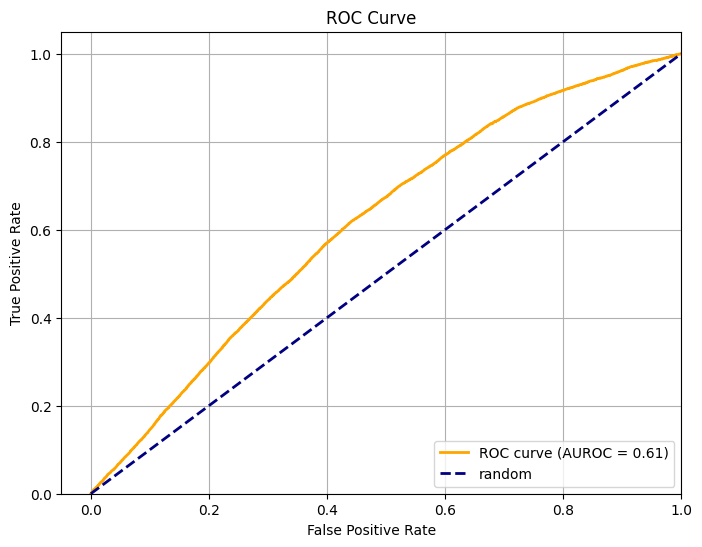

In [12]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (True, 0.8208898405900548)


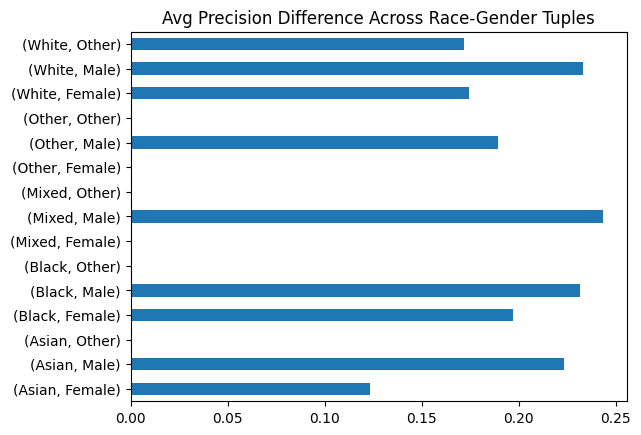

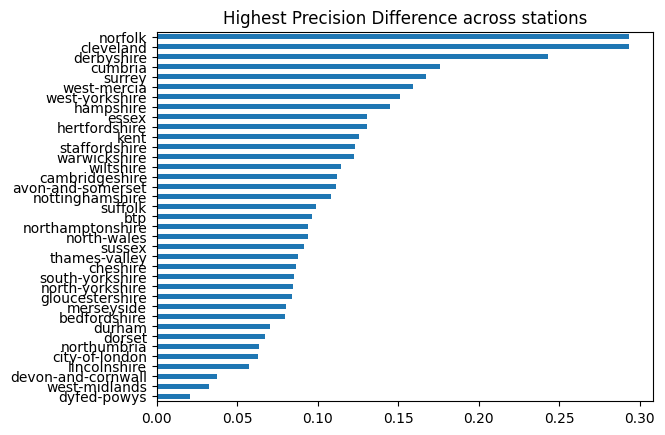

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.2330480811451127, ('White', 'Female'): 0.17456437967964242, ('White', 'Other'): 0.17152961980548187, ('Black', 'Male'): 0.2316144040589281, ('Black', 'Female'): 0.19675914533069475, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.22312640411031176, ('Asian', 'Female'): 0.12322894273988666, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2434262027177585, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.18930423792049386, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.11300108108108109


In [13]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hypothesis 2: GradientBoosting

# Get the data

In [14]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [15]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Run Hyperparameter Tuning

In [16]:
y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]
max_depths = [5, 10, 25]
learning_rate = [.1, .5, .9]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)

for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for lr in learning_rate:
        yvalues = []
        for n in n_estimators:
            model = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)

            pipeline, X_train, y_train = create_pipeline(df_train, model)
            y_pred_test = pipeline.predict(X_test)
            
            precision = precision_score(y_test, y_pred_test, pos_label=True)
            recall = recall_score(y_test, y_pred_test, pos_label=True)
            print(f"max_depths: {d} ; learning rate: {lr} ; n_estimators: {n}\n  Precission: {precision} ; Recall: {recall}")
            yvalues.append(recall)

            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_model = model
        values[lr] = yvalues

max_depths: 5 ; learning rate: 0.1 ; n_estimators: 5
  Precission: 0.23967628476519248 ; Recall: 0.7004044729954794
max_depths: 5 ; learning rate: 0.1 ; n_estimators: 10
  Precission: 0.24112276489543186 ; Recall: 0.7263859148227456
max_depths: 5 ; learning rate: 0.1 ; n_estimators: 25
  Precission: 0.2437990756584734 ; Recall: 0.7254342136569117
max_depths: 5 ; learning rate: 0.1 ; n_estimators: 50
  Precission: 0.24573345807658806 ; Recall: 0.724910778015703
max_depths: 5 ; learning rate: 0.1 ; n_estimators: 75
  Precission: 0.2466269679419202 ; Recall: 0.7193433261955746
max_depths: 5 ; learning rate: 0.1 ; n_estimators: 100
  Precission: 0.2470241023118544 ; Recall: 0.716916488222698
max_depths: 5 ; learning rate: 0.1 ; n_estimators: 200
  Precission: 0.24856374323381927 ; Recall: 0.7123483226266952
max_depths: 5 ; learning rate: 0.1 ; n_estimators: 300
  Precission: 0.24956075032211644 ; Recall: 0.7096835593623603
max_depths: 5 ; learning rate: 0.1 ; n_estimators: 400
  Precission

In [17]:
best_model

GradientBoostingClassifier(max_depth=10, n_estimators=10)

# Run Overfitting Test

5
10
25
50
75
100
200
300
400


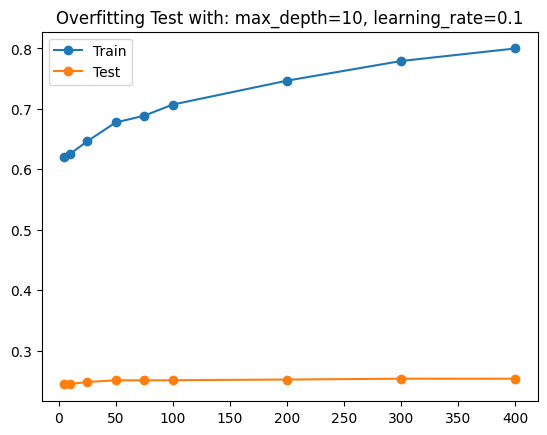

In [20]:
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()
train_scores = []
test_scores = []

for n in n_estimators:
    print(n)
    pipeline, X_train, y_train = create_pipeline(df_train, GradientBoostingClassifier(n_estimators=n, max_depth=10, learning_rate=0.1))

    # get the predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    train_prec = precision_score(y_train, y_pred_train)
    train_scores.append(train_prec)

    test_prec = precision_score(y_test, y_pred_test)
    test_scores.append(test_prec)

# plot of train and test scores vs tree depth
plt.plot(n_estimators, train_scores, '-o', label='Train')
plt.plot(n_estimators, test_scores, '-o', label='Test')
plt.title("Overfitting Test with: max_depth=10, learning_rate=0.1")
plt.legend()
plt.show()

# Train Best Model

In [21]:
pipeline, X_train, y_train = create_pipeline(df_train, GradientBoostingClassifier(n_estimators=5, max_depth=10, learning_rate=0.1))

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)

,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,0.0,0.826087,0.666667,0.54514,0.55516,0.0,0.584645,0.698278
1,0.0,1.0,0.73913,1.0,0.484365,0.55516,0.0,0.252933,0.739332
2,0.333333,0.0,0.652174,0.333333,0.484365,0.55516,0.0,0.511023,0.65343
3,0.0,0.0,0.391304,0.333333,0.484365,0.55516,0.0,0.471838,0.539571
4,0.333333,0.0,0.73913,0.166667,0.54514,0.55516,0.0,0.50235,0.695199
...,...,...,...,...,...,...,...,...,...
98769,0.333333,1.0,0.043478,0.5,0.54514,0.55516,0.0,0.063275,0.40027
98770,0.0,1.0,0.565217,0.166667,0.484365,0.55516,0.0,0.27568,0.777481
98771,1.0,1.0,0.217391,0.333333,0.54514,0.55516,0.0,0.464807,0.526711
98772,1.0,1.0,0.695652,0.833333,0.484365,0.331967,0.0,0.659453,0.522612


# Predict

In [22]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate Best One

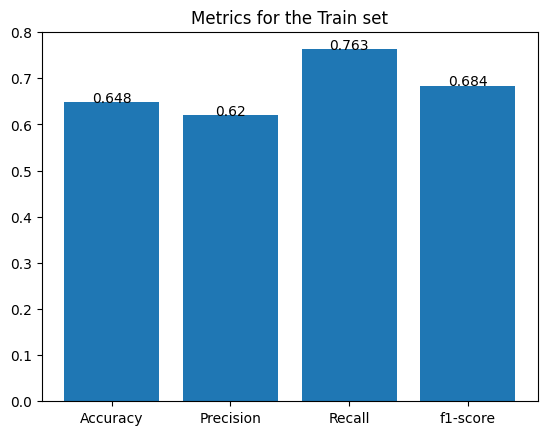

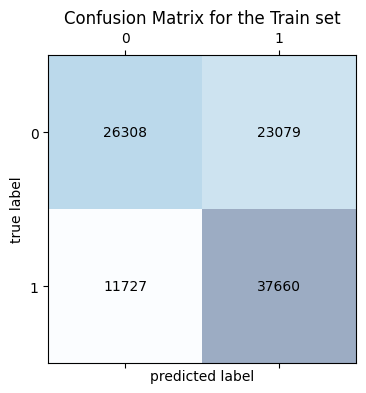

In [23]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

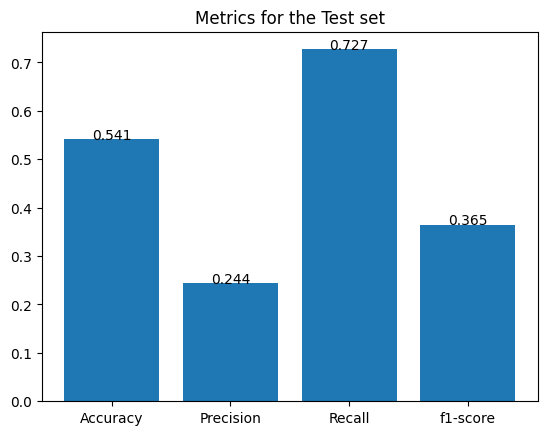

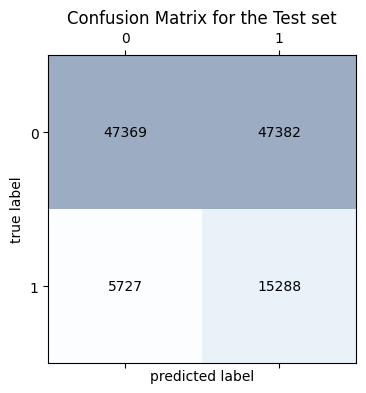

In [24]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

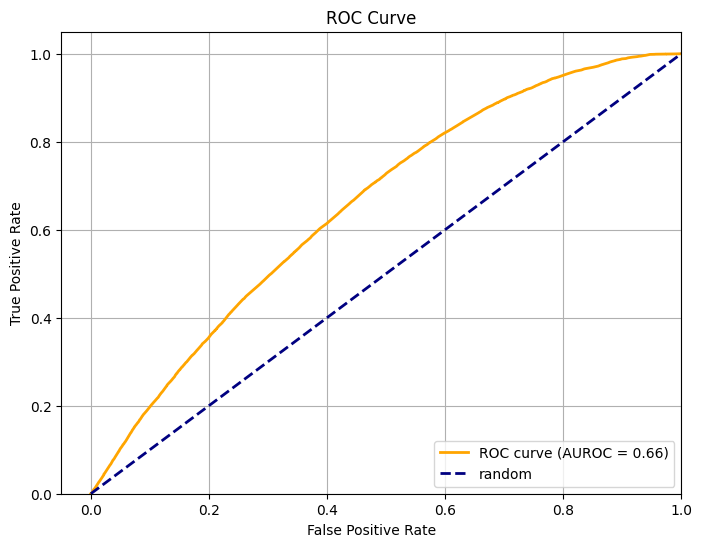

In [25]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.7274803711634547)


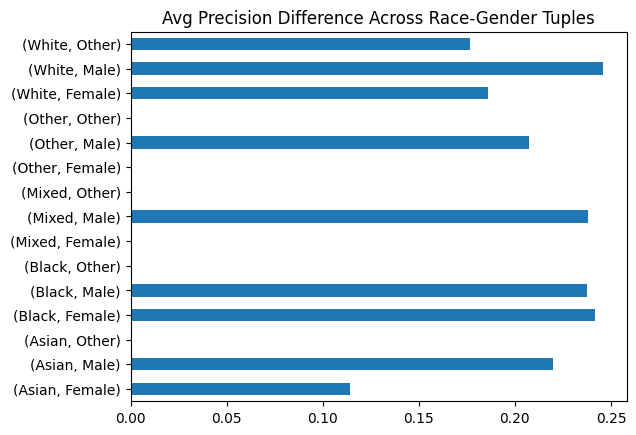

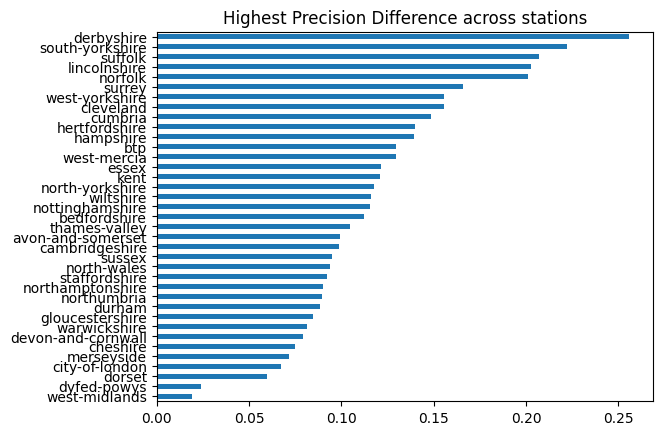

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.24589998850354744, ('White', 'Female'): 0.18623354460534236, ('White', 'Other'): 0.17638984214138642, ('Black', 'Male'): 0.2377338296059168, ('Black', 'Female'): 0.2415156367394534, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.21993601212419575, ('Asian', 'Female'): 0.11431623931623933, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.23785115780022398, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.20748502030322563, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 35
Num good departments: 2
avg diff: 0.11807945945945944


In [26]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")